# Shaped pupil propagation through IFS

This notebook illustrates processing the Shaped Pupil time series from J. Krist through the IFS. We produce realistic IFS detector maps and reduce them using crispy.

## 1. Reference star processing

For this first step, we only process the reference star time series

In [1]:
os5folder = '/local/data/nicolaus2/mrizzo/haystacks/for_gsfc/with_lowfc'
nref = 30 # only the first 30 images are from the reference star

In [2]:
import glob
filelist = glob.glob(os5folder+'/*')
filelist.sort()

In [3]:
filelist[0].split('/')[-1].split('.')[0]

'os5_spc_001'

Imports

In [4]:
import numpy as np
import astropy.units as u
import astropy.constants as c
import astropy.analytic_functions as af
from astropy.io import fits


In [5]:
cube = fits.open(filelist[0])[0]
# offaxispsf= '/local/data/nicolaus2/mrizzo/haystacks/for_gsfc/spc_offaxis_psf.fits'
# cube = fits.open(offaxispsf)[0]

print(cube.data.shape)
print(np.sum(cube.data))

(45, 315, 315)
6.15106675942e-08


### Process a cube to turn it into counts per pixel

In [6]:
# what is the area of the WFIRST pupil?
import webbpsf
from webbpsf import wfirst
webbpsf.setup_logging('ERROR') # Reduce the verbosity
diskspc = wfirst.CGI()
_ = diskspc.calc_psf(display=False)
pupil_pix_area = (diskspc.optsys.planes[0].pixelscale*u.pix)**2
tel_pupil_area = np.sum(diskspc.optsys.planes[0].amplitude)*pupil_pix_area


BW=0.18
lamc = 770*u.nanometer
Nlam=45
lamlist = lamc*np.linspace(1.-BW/2.,1.+BW/2.,Nlam)

def convert_cube(cube,lamlist,star_T,star_Vmag,tel_area):
    '''
    This functions calculates the number of photons per second
    entering the WFIRST obscured aperture
    '''
    
    
    # We need to determine the coefficient of proportionality between a blackbody source and the
    # actualy flux received (depends on size of the star, distance, etc)
    # define Vband
    lambda_cent = 550*u.nanometer

    # this is the flux density per steradian (specific intensity) you would expect from Vband
    flux_bb_F550 = af.blackbody_nu(lambda_cent, star_T).to(u.Watt/u.m**2/u.Hertz/u.sr)

    # this is the actual flux density received in Vband
    Vband_zero_pt = (3953*u.Jansky).to(u.Watt/u.m**2/u.Hertz)
    flux_star_Vband = Vband_zero_pt*10**(-0.4*star_Vmag)

    # the ratio is coefficient we seek; this will multiply a blackbody function to yield flux densities
    # at all wavelengths
    ratio_star = (flux_star_Vband/flux_bb_F550)

    # this is the ratio which we want to multiply phot_Uma_Vband for the other bands
    #print("Ratio of blackbodies is %f" % ratio_Uma)

    # Now convert each slice to photons per second per square meter
    dlam = lamlist[1]-lamlist[0]
    newcube=np.zeros(cube.shape)
    for i in range(len(lamlist)):
        high = c.c/(lamlist[i]-dlam/2.)
        low = c.c/(lamlist[i]+dlam/2.)
        mid = 0.5*(low+high) # middle frequency
        dnu = high-low
        E_ph = (c.h*mid).to(u.J) # photon energy at middle frequency
        BBlam = af.blackbody_nu(lamlist[i], star_T).to(u.Watt/u.m**2/u.Hertz/u.sr)
        flux = (BBlam*ratio_star*dnu).to(u.W/u.m**2) # this is Watts per m2
        photon_flux = flux/E_ph # This is in Photons per second per m2
        # also divide by pixel size 
        newcube[i,:,:] += photon_flux.to(1./u.s/u.m**2)
        #newcube[i] += (photon_flux.to(1./u.s/u.m**2)).value#*(0.1*(lamc.to(u.m)).value/(2.34))**2
    
    newcube *= len(lamlist)*tel_area
    return newcube

# reference star
beta_Uma_T = 9377*u.K # Thanks wikipedia
beta_Uma_Vmag = 2.37 # Thanks wikipedia
beta_Uma_cube = convert_cube(cube,lamlist,beta_Uma_T,beta_Uma_Vmag,tel_pupil_area)

Uma47_T = 5887*u.K # Thanks wikipedia
Uma47_Vmag = 5.03 # Thanks wikipedia
Uma47_cube = convert_cube(cube,lamlist,Uma47_T,Uma47_Vmag,tel_pupil_area)


WebbPSF log messages of level ERROR and above will be shown.
WebbPSF log outputs will be directed to the screen.


## Process the files using the function above

First, set up the IFS sim

In [7]:
import sys
folder = '../code'
if folder not in sys.path: sys.path.append(folder)
from IFS import propagateIFS
from params import Params
import logging
from tools.image import Image
#from tools.initLogger import initLogger
import os
os.chdir(folder)
par = Params()
logging.basicConfig(filename = par.exportDir+'/IFS.log',level=logging.INFO)
# log = logging.getLogger('main')
par.saveRotatedInput = False
par.saveDetector = False



### Reference star

In [11]:

for reffile in filelist[:nref]:
    print('Processing file '+reffile.split('/')[-1])
    cube = fits.open(reffile)[0]
    cube.data*=beta_Uma_cube
    # adjust headers for slightly different wavelength
    cube.header['LAM_C']=0.77
    # by NOT changing the pixelsize, we implicitly assume that the PSF is the same at 770 then at 800
    #cube.header['PIXSIZE']*=0.8/0.77
    detectorFrame = propagateIFS(par,lamlist.value/1000.,cube)
    ### NEED TO ADD HEADERS HERE!!!
    Image(data = detectorFrame).write('OS5/'+reffile.split('/')[-1].split('.')[0]+'_beta_Uma_IFS.fits',clobber=True)

Processing file os5_spc_001.fits


../code/tools/lenslet.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  paddedImagePlane = np.zeros((imagePlane.shape[0]*np.sqrt(2),imagePlane.shape[1]*np.sqrt(2)))
../code/tools/lenslet.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  paddedImagePlane[xpad:-xpad,ypad:-ypad] = imagePlane
../code/tools/detutils.py:64: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  temp = np.zeros((shape[1], x),dtype=float)
../code/tools/detutils.py:89: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  result = np.zeros((shape[0], shape[1]), dtype=float)
[astropy] AstropyDeprecationWarning: "clobber" was deprecated in version 1.3 and will be removed in a future version. Use argument "overwrite" instead.


Processing file os5_spc_002.fits
Processing file os5_spc_003.fits
Processing file os5_spc_004.fits
Processing file os5_spc_005.fits
Processing file os5_spc_006.fits
Processing file os5_spc_007.fits
Processing file os5_spc_008.fits
Processing file os5_spc_009.fits
Processing file os5_spc_010.fits
Processing file os5_spc_011.fits
Processing file os5_spc_012.fits
Processing file os5_spc_013.fits
Processing file os5_spc_014.fits
Processing file os5_spc_015.fits
Processing file os5_spc_016.fits
Processing file os5_spc_017.fits
Processing file os5_spc_018.fits
Processing file os5_spc_019.fits
Processing file os5_spc_020.fits
Processing file os5_spc_021.fits
Processing file os5_spc_022.fits
Processing file os5_spc_023.fits
Processing file os5_spc_024.fits
Processing file os5_spc_025.fits
Processing file os5_spc_026.fits
Processing file os5_spc_027.fits
Processing file os5_spc_028.fits
Processing file os5_spc_029.fits
Processing file os5_spc_030.fits


### Process the target star

In [12]:
for reffile in filelist[nref:]:
    print('Processing file '+reffile.split('/')[-1])
    cube = fits.open(reffile)[0]
    cube.data*=Uma47_cube
    # adjust headers for slightly different wavelength
    cube.header['LAM_C']=0.77
    # by NOT changing the pixelsize, we implicitly assume that the PSF is the same at 770 then at 800
    #cube.header['PIXSIZE']*=0.8/0.77
    detectorFrame = propagateIFS(par,lamlist.value/1000.,cube)
    ### NEED TO ADD HEADERS HERE!!!
    Image(data = detectorFrame).write('OS5/'+reffile.split('/')[-1].split('.')[0]+'_Uma47_IFS.fits',clobber=True)

Processing file os5_spc_031.fits


../code/tools/lenslet.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  paddedImagePlane = np.zeros((imagePlane.shape[0]*np.sqrt(2),imagePlane.shape[1]*np.sqrt(2)))
../code/tools/lenslet.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  paddedImagePlane[xpad:-xpad,ypad:-ypad] = imagePlane
../code/tools/detutils.py:64: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  temp = np.zeros((shape[1], x),dtype=float)
../code/tools/detutils.py:89: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  result = np.zeros((shape[0], shape[1]), dtype=float)
[astropy] AstropyDeprecationWarning: "clobber" was deprecated in version 1.3 and will be removed in a future version. Use argument "overwrite" instead.


Processing file os5_spc_032.fits
Processing file os5_spc_033.fits
Processing file os5_spc_034.fits
Processing file os5_spc_035.fits
Processing file os5_spc_036.fits
Processing file os5_spc_037.fits
Processing file os5_spc_038.fits
Processing file os5_spc_039.fits
Processing file os5_spc_040.fits
Processing file os5_spc_041.fits
Processing file os5_spc_042.fits
Processing file os5_spc_043.fits
Processing file os5_spc_044.fits
Processing file os5_spc_045.fits
Processing file os5_spc_046.fits
Processing file os5_spc_047.fits
Processing file os5_spc_048.fits
Processing file os5_spc_049.fits
Processing file os5_spc_050.fits
Processing file os5_spc_051.fits
Processing file os5_spc_052.fits
Processing file os5_spc_053.fits
Processing file os5_spc_054.fits
Processing file os5_spc_055.fits
Processing file os5_spc_056.fits
Processing file os5_spc_057.fits
Processing file os5_spc_058.fits
Processing file os5_spc_059.fits
Processing file os5_spc_060.fits
Processing file os5_spc_061.fits
Processing

## Apply detector readout, noise and averaging

Now we apply a detector readout scheme. Let's start by dividing each image (1000s) into integrations of 100 seconds. Then average all images for beta Uma and 47Uma. Extract beta Uma and 47Uma from the averaged images, and subtract beta Uma from 47Uma. 

In [19]:
from tools.detector import readDetector
filelist = glob.glob('OS5/os5_spc*.fits')
filelist.sort()
QE=0.7
losses = 0.34
Nreads = 10
timeframe = 1000. # number of seconds for each frame, set by J Krist
for reffile in filelist:
    print('Processing file '+reffile.split('/')[-1])
    img = Image(filename=reffile)
    inttime = timeframe/Nreads
    img.data*=QE*losses
    # refreshes parameter header
    par.makeHeader()
    par.hdr.append(('QE',QE,'Quantum efficiency of the detector'),end=True)
    par.hdr.append(('LOSS',losses,'Transmission factor for the IFS (J. Krist)'),end=True)
    par.hdr.append(('INTTIME',inttime,'Time for each infividual frame'),end=True)
    par.hdr.append(('NREADS',Nreads,'Number of frames averaged'),end=True)
    par.hdr.append(('EXPTIME',timeframe,'Total exposure time'),end=True)

    frame = np.zeros(img.data.shape)
    varframe = np.zeros(img.data.shape)
    # averaging reads
    for i in range(Nreads):
        newread = readDetector(par,img,inttime=inttime)
        frame += newread
        varframe += newread**2
    frame /= Nreads
    varframe /= Nreads
    varframe -= frame**2
    outimg = Image(data=frame,ivar=1./varframe,header=par.hdr)
    outimg.write('OS5/OS5_detector/'+reffile.split('/')[-1].split('.')[0]+'_detector.fits',clobber=True)


Processing file os5_spc_001_beta_Uma_IFS.fits


/local/data/nicolaus2/mrizzo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in true_divide
[astropy] AstropyDeprecationWarning: "clobber" was deprecated in version 1.3 and will be removed in a future version. Use argument "overwrite" instead.
[astropy] VerifyWarning: Card is too long, comment will be truncated.


Processing file os5_spc_002_beta_Uma_IFS.fits
Processing file os5_spc_003_beta_Uma_IFS.fits
Processing file os5_spc_004_beta_Uma_IFS.fits
Processing file os5_spc_005_beta_Uma_IFS.fits
Processing file os5_spc_006_beta_Uma_IFS.fits
Processing file os5_spc_007_beta_Uma_IFS.fits
Processing file os5_spc_008_beta_Uma_IFS.fits
Processing file os5_spc_009_beta_Uma_IFS.fits
Processing file os5_spc_010_beta_Uma_IFS.fits
Processing file os5_spc_011_beta_Uma_IFS.fits
Processing file os5_spc_012_beta_Uma_IFS.fits
Processing file os5_spc_013_beta_Uma_IFS.fits
Processing file os5_spc_014_beta_Uma_IFS.fits
Processing file os5_spc_015_beta_Uma_IFS.fits
Processing file os5_spc_016_beta_Uma_IFS.fits
Processing file os5_spc_017_beta_Uma_IFS.fits
Processing file os5_spc_018_beta_Uma_IFS.fits
Processing file os5_spc_019_beta_Uma_IFS.fits
Processing file os5_spc_020_beta_Uma_IFS.fits
Processing file os5_spc_021_beta_Uma_IFS.fits
Processing file os5_spc_022_beta_Uma_IFS.fits
Processing file os5_spc_023_beta_U

### Average the images

In [26]:
beta_Uma_files = glob.glob('OS5/OS5_detector/*beta*.fits')

beta_Uma = np.zeros(Image(filename=beta_Uma_files[0]).data.shape)
for beta_Uma_file in beta_Uma_files:
    beta_Uma += Image(filename=beta_Uma_file).data
beta_Uma/=len(beta_Uma_files)
Image(data=beta_Uma).write('OS5/OS5_average/average_beta_Uma_detector.fits',clobber=True)

Uma47_files = glob.glob('OS5/OS5_detector/*47*.fits')

Uma47 = np.zeros(Image(filename=Uma47_files[0]).data.shape)
for Uma47_file in Uma47_files:
    Uma47 += Image(filename=Uma47_file).data
Uma47/=len(Uma47_files)
Image(data=Uma47).write('OS5/OS5_average/average_Uma47_detector.fits',clobber=True)


[astropy] AstropyDeprecationWarning: "clobber" was deprecated in version 1.3 and will be removed in a future version. Use argument "overwrite" instead.


# Extraction

In [29]:
from IFS import reduceIFSMap
fname='OS5/OS5_average/average_beta_Uma_detector.fits'
cube_beta = reduceIFSMap(par,fname)
fname='OS5/OS5_average/average_Uma47_detector.fits'
cube_47 = reduceIFSMap(par,fname)

[astropy] AstropyDeprecationWarning: "clobber" was deprecated in version 1.3 and will be removed in a future version. Use argument "overwrite" instead.
[astropy] VerifyWarning: Card is too long, comment will be truncated.
[astropy] AstropyDeprecationWarning: "clobber" was deprecated in version 1.3 and will be removed in a future version. Use argument "overwrite" instead.
[astropy] VerifyWarning: Card is too long, comment will be truncated.


### Need to subtract reference psf from star psf

In [ ]:
# naive subtraction
sum_beta = np.nansum(cube_beta.data)
print(sum_beta.data.shape)
sum_47 = np.nansum(cube_47.data)
residual = cube_47.data-10**(0.4*(beta_Uma_Vmag-Uma47_Vmag))*cube_beta.data
Image(data=residual).write('OS5/OS5_average/residual.fits',clobber=True)


# Add off-axis PSF

In [35]:
offaxispsf= '/local/data/nicolaus2/mrizzo/haystacks/for_gsfc/spc_offaxis_psf.fits'
cube = fits.open(offaxispsf)[0]
print('Processing file '+offaxispsf)
Uma47_cube_off_axis = convert_cube(cube,lamlist,Uma47_T,Uma47_Vmag,tel_pupil_area)
cube.data*=Uma47_cube_off_axis
# adjust headers for slightly different wavelength
cube.header['LAM_C']=0.77
# by NOT changing the pixelsize, we implicitly assume that the PSF is the same at 770 then at 800
#cube.header['PIXSIZE']*=0.8/0.77
par.saveDetector=False
detectorFrame = propagateIFS(par,lamlist.value/1000.,cube)
### NEED TO ADD HEADERS HERE!!!
Image(data = detectorFrame).write('OS5/offaxis.fits',clobber=True)

Processing file /local/data/nicolaus2/mrizzo/haystacks/for_gsfc/spc_offaxis_psf.fits


../code/tools/lenslet.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  paddedImagePlane = np.zeros((imagePlane.shape[0]*np.sqrt(2),imagePlane.shape[1]*np.sqrt(2)))
../code/tools/lenslet.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  paddedImagePlane[xpad:-xpad,ypad:-ypad] = imagePlane
../code/tools/detutils.py:64: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  temp = np.zeros((shape[1], x),dtype=float)
../code/tools/detutils.py:89: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  result = np.zeros((shape[0], shape[1]), dtype=float)
[astropy] AstropyDeprecationWarning: "clobber" was deprecated in version 1.3 and will be removed in a future version. Use argument "overwrite" instead.


### Add off-axis PSF before applying detector

In [38]:
from tools.detector import readDetector
filelist = glob.glob('OS5/os5_spc*.fits')
filelist.sort()
QE=0.7
losses = 0.34
Nreads = 10
timeframe = 1000. # number of seconds for each frame, set by J Krist

contrast = 1e-8 # contrast of planet
for reffile in filelist:
#     print('Processing file '+reffile.split('/')[-1])
    img = Image(filename=reffile)
    inttime = timeframe/Nreads
    img.data*=QE*losses
    # refreshes parameter header
    par.makeHeader()
    par.hdr.append(('QE',QE,'Quantum efficiency of the detector'),end=True)
    par.hdr.append(('LOSS',losses,'Transmission factor for the IFS (J. Krist)'),end=True)
    par.hdr.append(('INTTIME',inttime,'Time for each infividual frame'),end=True)
    par.hdr.append(('NREADS',Nreads,'Number of frames averaged'),end=True)
    par.hdr.append(('EXPTIME',timeframe,'Total exposure time'),end=True)

    
    # subtract offaxis psf if Uma47 is in filename
    if 'Uma47' in reffile:
        off_axis_psf = Image(filename='OS5/offaxis.fits')
        img.data += contrast*off_axis_psf.data
    frame = np.zeros(img.data.shape)
    varframe = np.zeros(img.data.shape)
    # averaging reads
    for i in range(Nreads):
        newread = readDetector(par,img,inttime=inttime)
        frame += newread
        varframe += newread**2
    frame /= Nreads
    varframe /= Nreads
    varframe -= frame**2
    outimg = Image(data=frame,ivar=1./varframe,header=par.hdr)
    outimg.write('OS5/OS5_with_target_detector/'+reffile.split('/')[-1].split('.')[0]+'_detector.fits',clobber=True)


/local/data/nicolaus2/mrizzo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: RuntimeWarning: divide by zero encountered in true_divide
[astropy] AstropyDeprecationWarning: "clobber" was deprecated in version 1.3 and will be removed in a future version. Use argument "overwrite" instead.
[astropy] VerifyWarning: Card is too long, comment will be truncated.


### Average the images

In [39]:
beta_Uma_files = glob.glob('OS5/OS5_with_target_detector/*beta*.fits')

Uma47_files = glob.glob('OS5/OS5_with_target_detector/*47*.fits')

Uma47 = np.zeros(Image(filename=Uma47_files[0]).data.shape)
for Uma47_file in Uma47_files:
    Uma47 += Image(filename=Uma47_file).data
Uma47/=len(Uma47_files)
Image(data=Uma47).write('OS5/OS5_average/average_Uma47_offaxis_detector.fits',clobber=True)


[astropy] AstropyDeprecationWarning: "clobber" was deprecated in version 1.3 and will be removed in a future version. Use argument "overwrite" instead.


### Reduction

In [41]:
fname='OS5/OS5_average/average_Uma47_offaxis_detector.fits'
cube_47_offaxis = reduceIFSMap(par,fname)

[astropy] AstropyDeprecationWarning: "clobber" was deprecated in version 1.3 and will be removed in a future version. Use argument "overwrite" instead.
[astropy] VerifyWarning: Card is too long, comment will be truncated.


### Naive PSF subtraction

In [42]:
# naive subtraction
residual = cube_47_offaxis.data-10**(0.4*(beta_Uma_Vmag-Uma47_Vmag))*cube_beta.data
Image(data=residual).write('OS5/OS5_average/residual_offaxis.fits',clobber=True)


[astropy] AstropyDeprecationWarning: "clobber" was deprecated in version 1.3 and will be removed in a future version. Use argument "overwrite" instead.


# SNR calculation

In [43]:
# still naive subtraction, but subtract off the means
cube47_noave = cube_47_offaxis.data - np.nanmean(cube_47_offaxis.data)
cubebeta_noave = cube_beta.data - np.nanmean(cube_beta.data)
residual = cube47_noave-10**(0.4*(beta_Uma_Vmag-Uma47_Vmag))*cubebeta_noave


### Construct a matched filter

In [56]:
#offaxis_ideal = reduceIFSMap(par,'OS5/offaxis.fits')
matched_filter = contrast*offaxis_ideal.data[0]/np.nansum((contrast*offaxis_ideal.data[0])**2)
psf_fit = np.nansum(matched_filter*residual)
print(psf_fit)
print(np.nanstd(residual[0]))

1644.5393324
0.0117783064753


In [49]:
print(offaxis_ideal.data.shape)

(17, 108, 108)


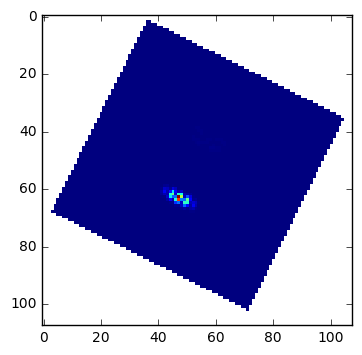

In [51]:
import matplotlib.pyplot as plt
plt.imshow(offaxis_ideal.data[0],interpolation='nearest')
plt.show()